## Spot Virat Kohli

In [2]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.


## Step 1: Download images of Kohli, Rohit, and MS

In [4]:
!pip install fastbook -q

from fastdownload import download_url

from fastai.vision.all import *


In [5]:
from fastbook import *
def search_images(term, max=30):
  print(f"Searching for '{term}'")
  return search_images_ddg(term, max_images=max)


Searching for 'virat kohli'


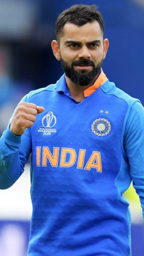

In [6]:
download_url(search_images('virat kohli', max=1)[0], 'v1.jpg', show_progress=False)
Image.open('v1.jpg').to_thumb(256,256)

Searching for 'rohit sharma'


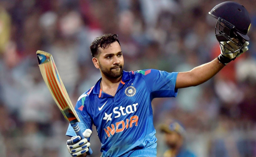

In [7]:
download_url(search_images('rohit sharma', max=1)[0], 'r1.jpg', show_progress=False)
Image.open('r1.jpg').to_thumb(256,256)

Searching for 'MS Dhoni'


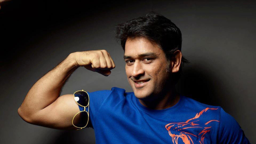

In [8]:
download_url(search_images('MS Dhoni', max=1)[0], 'd1.jpg', show_progress=False)
Image.open('d1.jpg').to_thumb(256,256)

In [9]:
searches = 'Virat Kohli','Rohit Sharma', 'MS Dhoni'
path = Path('kohli_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}', max = 100))
    sleep(10)  # Pause between searches to avoid over-loading server

Searching for 'Virat Kohli'
Searching for 'Rohit Sharma'
Searching for 'MS Dhoni'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

37

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

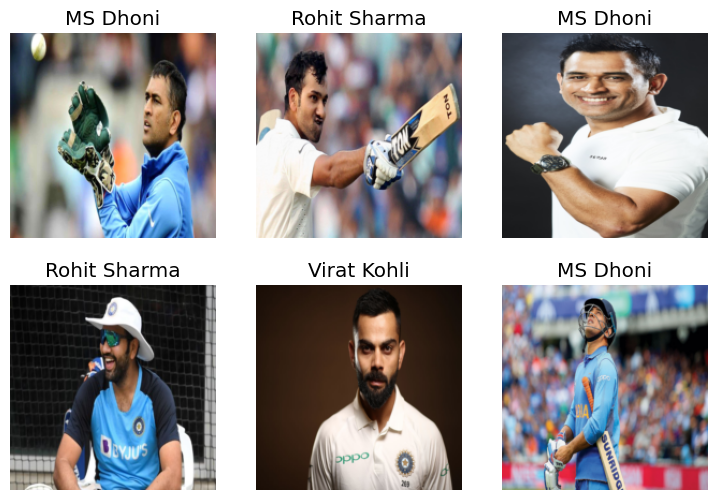

In [17]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=24)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [18]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(14)

epoch,train_loss,valid_loss,accuracy,time
0,2.047598,2.035036,0.392157,00:06


epoch,train_loss,valid_loss,accuracy,time
0,1.088899,1.294918,0.529412,00:06
1,0.787171,1.076805,0.549020,00:06
2,0.637121,0.975380,0.627451,00:06
3,0.476105,0.960454,0.588235,00:06
4,0.378859,0.958946,0.647059,00:06
5,0.299834,0.941621,0.666667,00:06
6,0.248297,0.967500,0.647059,00:06
7,0.206783,0.950829,0.666667,00:06
8,0.176183,0.926965,0.686275,00:06
9,0.145378,0.920098,0.686275,00:07


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

In [22]:
is_kohli,_,probs = learn.predict(PILImage.create('v1.jpg'))
print(f"This is a: {is_kohli}.")
print(f"Probability it's a {is_kohli}: {probs[0]:.4f}")

This is a: Virat Kohli.
Probability it's a Virat Kohli: 0.0002


Good job, resnet18. :)

So, as you see, in the space of a few years, creating computer vision classification models has gone from "so hard it's a joke" to "trivially easy and free"!

It's not just in computer vision. Thanks to deep learning, computers can now do many things which seemed impossible just a few years ago, including [creating amazing artworks](https://openai.com/dall-e-2/), and [explaining jokes](https://www.datanami.com/2022/04/22/googles-massive-new-language-model-can-explain-jokes/). It's moving so fast that even experts in the field have trouble predicting how it's going to impact society in the coming years.

One thing is clear -- it's important that we all do our best to understand this technology, because otherwise we'll get left behind!

Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.